In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator
from astropy import (coordinates as coord, units as u)
from astroquery.simbad import Simbad
from astropy.io import fits
from astropy.table import Table
from time import time

# Don't do this. Do as I say and not as I code.
import sys
sys.path.insert(0, "../") 

import mpl_utils
import mlf_utils as mlf
import stan_utils as stan

plt.style.use(mpl_utils.mpl_style)

%matplotlib inline

In [2]:
GALAH_CATALOG_PATH = "../catalogs/GALAH_DR2.1_catalog.fits"
galah = Table.read(GALAH_CATALOG_PATH)


In [3]:
galah

star_id,sobject_id,gaia_dr2_id,ndfclass,field_id,raj2000,dej2000,jmag,hmag,kmag,vmag_jk,e_jmag,e_hmag,e_kmag,snr_c1,snr_c2,snr_c3,snr_c4,rv_synt,e_rv_synt,rv_obst,e_rv_obst,rv_nogr_obst,e_rv_nogr_obst,chi2_cannon,sp_label_distance,flag_cannon,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,vsini,e_vsini,alpha_fe,e_alpha_fe,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,y_fe,e_y_fe,flag_y_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,eu_fe,e_eu_fe,flag_eu_fe
,,,,,deg,deg,mag,mag,mag,mag,mag,mag,mag,,,,,km / s,km / s,km / s,km / s,km / s,km / s,,,,K,K,log(cm/s**2),log(cm/s**2),,,km / s,km / s,km / s,km / s,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str16,int64,int64,str12,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64
00000011+0522500,170910004101274,2745049530295263232,MFOBJECT,6882,0.00047,5.380571,11.247,10.662,10.539,13.29013142182967,0.023,0.021,0.019,21.6842438247,25.642019541,48.2577818878,56.7736953398,11.2785006196,0.10554313024226696,nan,nan,nan,nan,0.9686406055148505,26.117479302928928,1,4576.3146556900165,73.66606152161543,4.69921301415962,0.20325334996983807,-0.34715658604637595,0.0858256649316195,1.0402612320260698,0.04780623250819824,5.842923719979717,1.137324347810317,nan,nan,0.08814637856703222,0.036974729677661515,9,0.1767276669285896,0.12066299569491594,7,0.917111108763486,0.12488473782575324,7,-0.02697108553652898,0.05739079406012904,3,-0.27784443564094446,0.09104559780809049,3,0.1192836438175516,0.05014576539801681,3,-0.5213135214004853,0.08367885808642318,4,-0.07828451329189948,0.1105459049204072,3,0.2636871283785336,0.06430052174371603,3,0.24947225252755315,0.05430142402788317,3,0.1993616391387553,0.04245711713403249,3,0.5272384234558806,0.06819817858156826,3,-0.017008873233296695,0.06848921533230523,3,-0.28099685115686907,0.07106827513025585,3,-0.032079478105687516,0.05902655519022573,3,0.09768408598746328,0.07118604779902064,3,0.03449119709150463,0.0675336516468829,3,-0.316891222233664,0.08378329657164789,4,0.2800804604999586,0.09618677820229367,3,0.0020769516248465847,0.11050615030944015,3,0.1513767947925168,0.06994674998573366,7,0.06383755210346904,0.14885420501563815,7
00000023-5709445,161116001701360,4922452332795612416,MFOBJECT,6863,0.000961,-57.162365,12.219,11.707,11.614,13.962700850910407,0.023,0.025,0.023,35.4352269965,44.8624165399,77.100807268,61.57035197,-17.0524752475,0.22204866610544016,nan,nan,nan,nan,1.1302555774403251,9.481671746009932,1,5168.714783718918,69.26343220626434,4.417376173707199,0.18537860563660696,-0.8399120515061285,0.07626677163678232,1.052628515431911,0.043236608109176955,8.310857910725424,1.0437913042541966,nan,nan,1.2327808340880901,0.034874843628975874,9,0.17228231706904168,0.09017881957321548,7,0.5019640877763372,0.11119965231157877,7,-0.024790781231829796,0.0519223318192827,3,0.277602119753392,0.08199969469069114,3,0.2546160563668588,0.04535553578385894

In [4]:
# What abundances are available?
element_label_names = ["fe_h"] + [ln for ln in galah.dtype.names \
    if ln.endswith("_fe") and not ln.startswith(("flag_", "e_", "alpha_"))]

is_ok = dict()
for label_name in element_label_names:
    if label_name == "fe_h":
        is_ok[label_name] = sum(galah["flag_cannon"] == 0)
    else:
        is_ok[label_name] = sum(galah["flag_{}".format(label_name)] == 0)
    
for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]:
    print(k, v)

na_fe 265806
mg_fe 264551
fe_h 264227
sc_fe 251749
ti_fe 250655
zn_fe 248993
mn_fe 247222
y_fe 244475
ca_fe 240420
ni_fe 235944
cr_fe 235783
o_fe 230613
si_fe 228337
k_fe 214247
ba_fe 206675
v_fe 184428
cu_fe 184380
al_fe 178739
la_fe 52715
eu_fe 42901
c_fe 29126
co_fe 18332
li_fe 3963


In [5]:
# Select the sample of elements to use.

# Top 15:
element_label_names = [k for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]]
element_label_names = element_label_names[:15]

y = np.array([galah[ln] for ln in element_label_names]).T

passes_qc = np.ones(y.shape[0], dtype=bool)
for label_name in element_label_names:
    if label_name == "fe_h": continue
    print(label_name, sum(passes_qc))
    passes_qc *= (galah["flag_{}".format(label_name)] == 0)

y = y[passes_qc]
N, D = y.shape

# Subtract [Fe/H] to make everything [X/H]
fe_h_index = element_label_names.index("fe_h")
for d in range(D):
    if d == fe_h_index: continue
    y[:, d] += y[:, fe_h_index]

mean = np.mean(y, axis=0)
y = y - mean

assert mean.size == D
assert N > D
assert np.all(np.isfinite(y))
assert np.allclose(np.mean(y, axis=0), np.zeros(D))

label_names = ["{}_h".format(ea.split("_")[0]) for ea in element_label_names]

na_fe 342682
mg_fe 265806
sc_fe 249105
ti_fe 227890
zn_fe 212069
mn_fe 194431
y_fe 183367
ca_fe 168143
ni_fe 157662
cr_fe 144703
o_fe 134054
si_fe 118259
k_fe 107326
ba_fe 91891


In [6]:
# Randomly sub-sample the data for faster testing?
subsample = None

if subsample is not None:
    print("Randomly subsampling {} stars".format(subsample))
    np.random.seed(42)
    y = y[np.random.choice(N, subsample, repeat=False)]


In [28]:
J = 2
N, D = y.shape
data = dict(y=y, N=N, D=D, J=J)

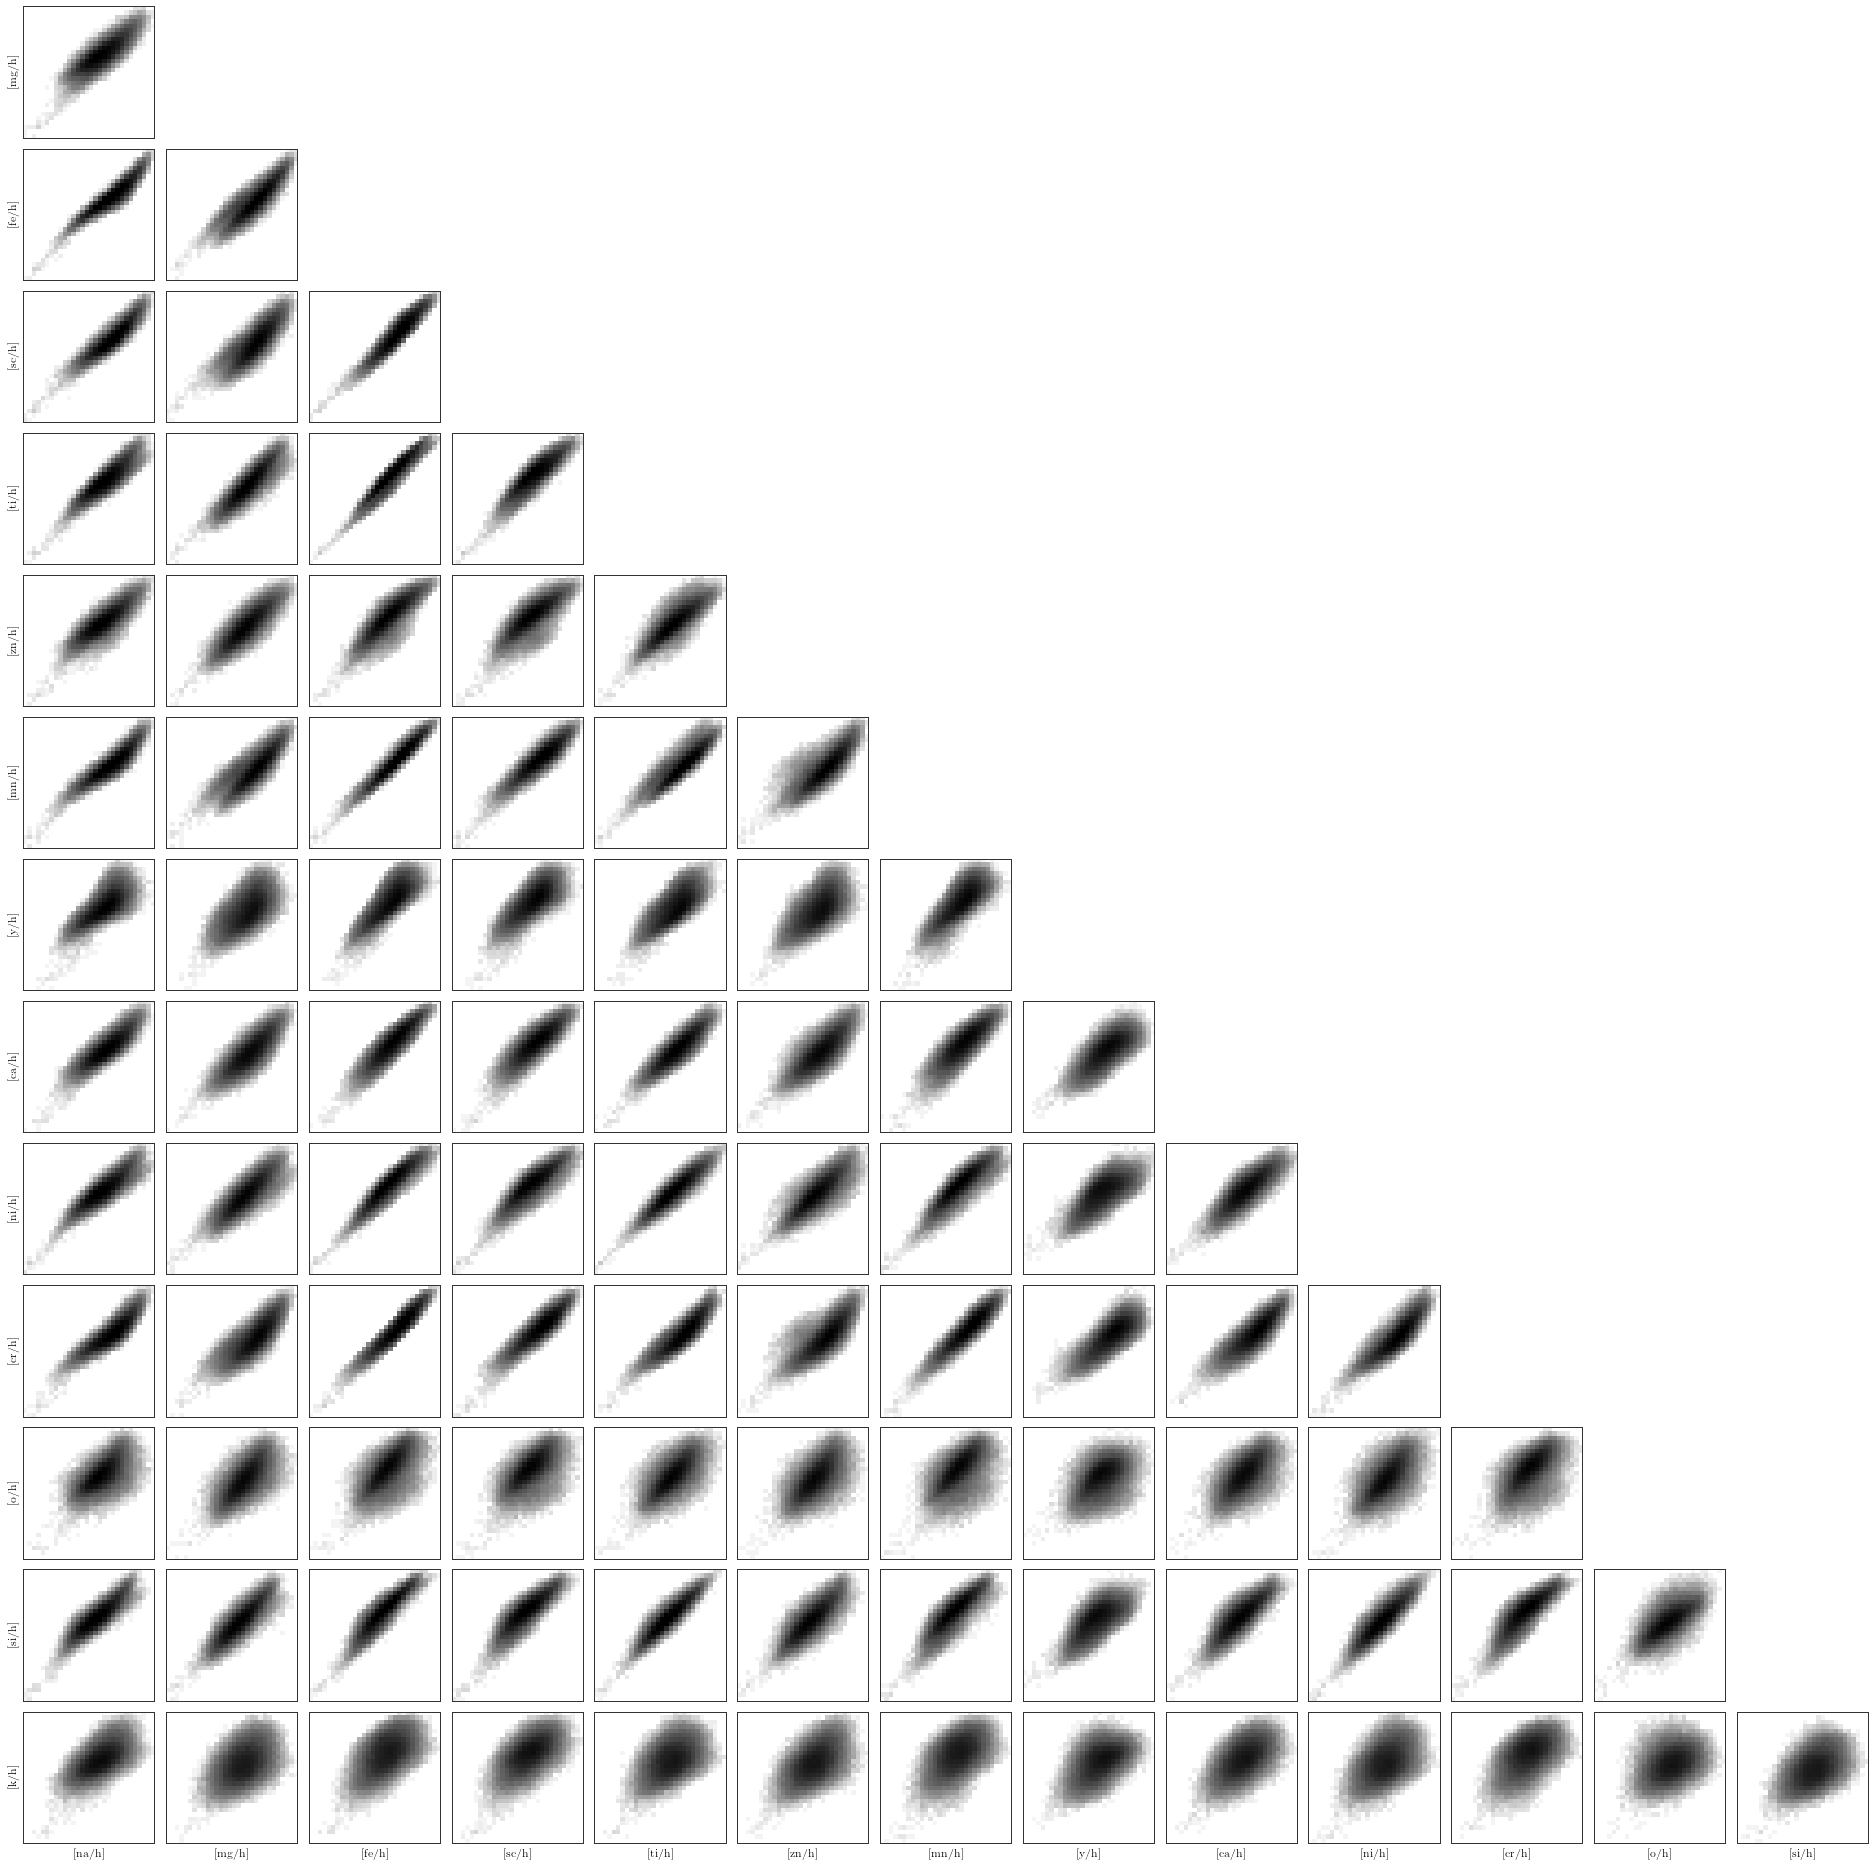

In [8]:
lln = lambda ln: r"\textrm{{[{0}]}}".format(ln.replace("_", "/"))

fig = mpl_utils.corner_hist(y, 
                            label_names=[lln(ln) for ln in label_names],
                            show_ticks=False)

In [29]:
# Run with our own model.
from model import LatentFactorModel

t_init = time()
lfm = LatentFactorModel(J, tol=1e-16)
lfm.fit(y)
print("Completed in {:.0f}s".format(time() - t_init))

0 -1086977.2464248785 0.00e+00
1 389252.29351571546 0.00e+00
2 909067.3896931326 0.00e+00
3 994451.2869976946 0.00e+00
4 1005256.1004778991 0.00e+00
5 1008103.573559761 0.00e+00
6 1009328.6683978206 0.00e+00
7 1009973.1519181805 0.00e+00
8 1010348.604667677 0.00e+00
9 1010582.2384676294 0.00e+00
10 1010734.8457755862 0.00e+00
11 1010838.3423839767 0.00e+00
12 1010910.6525427331 0.00e+00
13 1010962.3951185342 0.00e+00
14 1011000.1445091495 0.00e+00
15 1011028.1243946888 0.00e+00
16 1011049.1345386682 0.00e+00
17 1011065.0810118151 0.00e+00
18 1011077.2914758511 0.00e+00
19 1011086.7091006961 0.00e+00
20 1011094.015433808 0.00e+00
21 1011099.7103238828 0.00e+00
22 1011104.1651342907 0.00e+00
23 1011107.658914046 0.00e+00
24 1011110.4034422892 0.00e+00
25 1011112.560858219 0.00e+00
26 1011114.2562573366 0.00e+00
27 1011115.5868118113 0.00e+00
28 1011116.6284554325 0.00e+00
29 1011117.4408364602 0.00e+00
30 1011118.0710247303 0.00e+00
31 1011118.5563110212 0.00e+00
32 1011118.9263386645 0.

In [30]:
# Create an array of Z values for plotting, etc
Z = mlf.atomic_number(label_names)
zi = np.argsort(Z)
ordered_label_names = [label_names[i] for i in zi]
ordered_latex_label_names = [lln(oln) for oln in ordered_label_names]


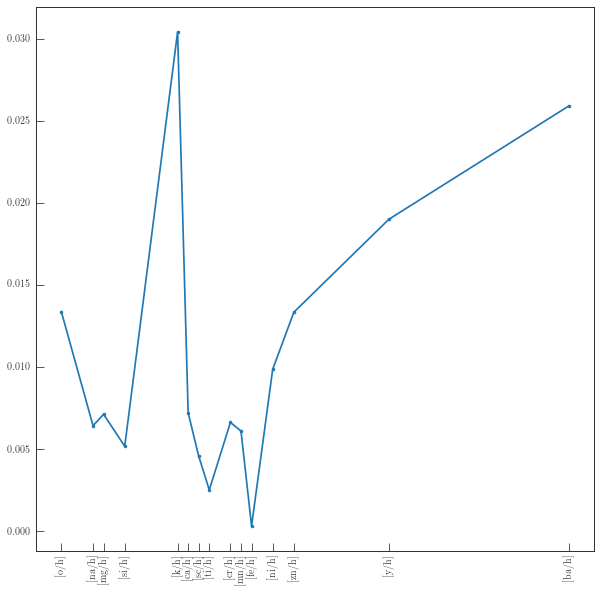

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(Z[zi], lfm.psi[zi])
ax.set_xticks(Z[zi])
_ = ax.set_xticklabels(ordered_latex_label_names, rotation=90)

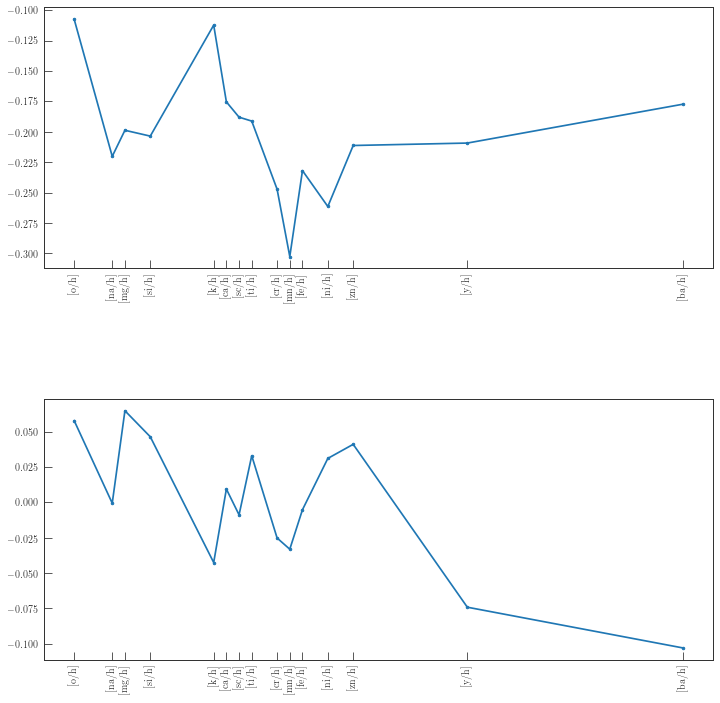

In [32]:
fig, axes = plt.subplots(J, 1, figsize=(12, 12))
ax.set_xticks(Z[zi])
ax.set_xticklabels(ordered_latex_label_names)
axes = np.atleast_1d(axes).flatten()

for j, ax in enumerate(axes):
    ax.plot(Z[zi], lfm.factor_loads[j][zi])
    ax.set_xticks(Z[zi])
    ax.set_xticklabels(ordered_latex_label_names, rotation=90)
    

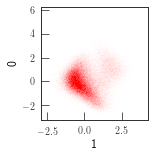

In [33]:
fig = mpl_utils.corner_scatter(lfm.factor_scores, 
                               label_names=np.arange(data["J"]),
                               show_ticks=True,
                               alpha=0.005, c="r")

In [ ]:
assert 0



In [ ]:
# Default optimization keywords in Stan.
default_op_kwds = dict(
    init_alpha=0.001,
    tol_obj=1e-12,
    tol_grad=1e-8,
    tol_param=1e-8,
    tol_rel_grad=1e7
)

op_kwds = default_op_kwds.copy()
op_kwds.update(
    iter=10000,
    data=data,
    tol_obj=1e-16,
    tol_grad=1e-16,
    tol_param=1e-16,
    tol_rel_grad=1e-16,
    init_alpha=1.0,
)

model = stan.load_stan_model("../mlf.stan")
opt = model.optimizing(**op_kwds)

INFO:root:Using pre-compiled model from ../mlf.stan.cached


In [ ]:
# Create an array of Z values for plotting, etc
Z = mlf.atomic_number(label_names)
zi = np.argsort(Z)
ordered_label_names = [label_names[i] for i in zi]
ordered_latex_label_names = [lln(oln) for oln in ordered_label_names]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(Z[zi], opt["psi"][zi])
ax.set_xticks(Z[zi])
_ = ax.set_xticklabels(ordered_latex_label_names, rotation=90)

In [ ]:
fig, axes = plt.subplots(J, 1, figsize=(9, 9))
ax.set_xticks(Z[zi])
ax.set_xticklabels(ordered_latex_label_names)
axes = np.atleast_1d(axes).flatten()

for j, ax in enumerate(axes):
    ax.plot(Z[zi], opt["L"].T[j][zi])
    ax.set_xticks(Z[zi])
    ax.set_xticklabels(ordered_latex_label_names, rotation=90)
    

In [ ]:
factor_scores = mlf.factor_scores(data["y"], opt["L"], opt["psi"])
fig = mpl_utils.corner_scatter(factor_scores, 
                               label_names=np.arange(data["J"]),
                               show_ticks=True,
                               alpha=0.01)

In [ ]:
# Now re-rank and run to see if it makes a difference.
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(J)
fa.fit(y)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(fa.components_, interpolation="nearest")

In [ ]:
ri, ci = mlf.rank_order_triu_matrix(fa.components_.T)

In [ ]:
ri

In [ ]:
rank_label_names = [label_names[i] for i in ri]
rank_y = y[:, ri]

In [ ]:
# Re-run optimization.
rank_data = dict(y=rank_y, N=N, D=D, J=J)

In [ ]:
# Default optimization keywords in Stan.
default_op_kwds = dict(
    init_alpha=0.001,
    tol_obj=1e-12,
    tol_grad=1e-8,
    tol_param=1e-8,
    tol_rel_grad=1e7
)

op_kwds = default_op_kwds.copy()
op_kwds.update(
    iter=10000,
    data=rank_data,
    tol_obj=1e-16,
    tol_grad=1e-16,
    tol_param=1e-16,
    tol_rel_grad=1e-16,
    init_alpha=1.0,
)


model = stan.load_stan_model("../mlf.stan")
rank_opt = model.optimizing(**op_kwds)

In [ ]:
Z_rank = atomic_number(rank_label_names)
zi_rank = np.argsort(Z_rank)


fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(Z[zi], opt["psi"][zi])
ax.plot(Z_rank[zi_rank], rank_opt["psi"][zi_rank], c="r")

ax.set_xticks(Z[zi])
_ = ax.set_xticklabels(ordered_latex_label_names, rotation=90)


In [ ]:
fig, axes = plt.subplots(J, 1, figsize=(9, 9))
ax.set_xticks(Z[zi])
ax.set_xticklabels(ordered_latex_label_names)
axes = np.atleast_1d(axes).flatten()

for j, ax in enumerate(axes):
    ax.plot(Z[zi], opt["L"].T[j][zi])
    ax.plot(Z_rank[zi_rank], rank_opt["L"].T[j][zi_rank], c="r")
    ax.set_xticks(Z[zi])
    ax.set_xticklabels(ordered_latex_label_names, rotation=90)
    

In [ ]:
rank_factor_scores = mlf.factor_scores(data["y"], rank_opt["L"], rank_opt["psi"])
fig = mpl_utils.corner_scatter(rank_factor_scores, 
                               label_names=np.arange(data["J"]),
                               show_ticks=True,
                               alpha=0.005, c="r")

In [ ]:
init

In [ ]:
init
